In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
from FilesFunc import files
folders = ["Background", "BH", "Sphaleron"]
stuffs = ["electron", "jet", "MET", "muon", "photon", "tau"]
data_variables = ["met", "HT", "stuff_amount", "ptmax", "phi_diff"]
file_amounts = [0, 18, 3]
font = {'family': 'Times New Roman',
        'color':  'black',
        'weight': 'normal'
        }

def work_space(path):
    while True:
        if os.path.split(path)[1] != "Phys117":
            path = os.path.split(path)[0]
        else:
            return path.replace("\\", "/")
work_dir = work_space(os.getcwd())


def remover(old_list, index):
    new_list = [element for element_index, element in enumerate(old_list) if element_index != index]
    return new_list


def unpacker(folder_data, new_folder_data):
    for nested_list in folder_data:
        if type(nested_list) == list or type(nested_list) == tuple:
            list_unpacker(nested_list, new_folder_data)
        else:
            new_folder_data.append(nested_list)
    folder_data = new_folder_data
    return folder_data


def list_unpacker(folder_data, new_folder_data):
    for nested_list in folder_data:
        if type(nested_list) == list:
            list_unpacker(nested_list, new_folder_data)
        else:
            new_folder_data.append(nested_list)
    folder_data = new_folder_data
    return folder_data


def tuple_unpacker(folder_data, new_folder_data):
    for nested_list in folder_data:
        if type(nested_list) == tuple:
            tuple_unpacker(nested_list, new_folder_data)
        else:
            new_folder_data.append(nested_list)
    folder_data = new_folder_data
    return folder_data


def eff_retriever(data_path, combine_data):
    filenames = os.listdir(data_path)
    filepaths = [data_path + filename for filename in filenames]
    if combine_data:
        dataframes = [pd.read_csv(filepath) for filepath in filepaths if filepath[-len("Combined.csv"):] == "Combined.csv"]
    else:
        dataframes = [pd.read_csv(filepath) for filepath in filepaths if filepath[-len("Combined.csv"):] != "Combined.csv"]
    return dataframes


def dropper(dataframe, data_variables):
    to_drop = [col for col in dataframe.columns if col not in data_variables]
    dataframe = dataframe.drop(to_drop, axis = 1)
    return dataframe


def dataframe_retriever(data_path, data_variables):
    folders = os.listdir(data_path)
    folder_filenames = [os.listdir(data_path + folder) for folder in folders]
    folder_filepaths = [[data_path + folder + "/" + filename for filename in folder_filenames[folder_index]] for folder_index, folder in enumerate(folders)]
    dataframes = [[(pd.read_csv(filepath).drop("Unnamed: 0", axis = 1), filename) for filepath, filename in zip(filepaths, filenames)] for filepaths, filenames in zip(folder_filepaths, folder_filenames)]
    return dataframes


def selector(folder_dataframes, folder_filenames):
    dataframes = [[dataframe[0] for dataframe in dataframes if dataframe[1] in filenames] for dataframes, filenames in zip(folder_dataframes, folder_filenames)]
    return dataframes


def eff_selector(combine_data, dataframes):
    if combine_data:
        dataframes = [dataframe[0].drop("Unnamed: 0", axis = 1).set_index(dataframe[0]["Unnamed: 0"]) for dataframe in dataframes if dataframe[1][-len("Combined.csv"):] == "Combined.csv"]
    else:
        dataframes = [dataframe[0].drop("Unnamed: 0", axis = 1).set_index(dataframe[0]["Unnamed: 0"]) for dataframe in dataframes if dataframe[1][-len("Combined.csv"):] != "Combined.csv"]
    
    return dataframes


def sampler(model_dataframes, file_amounts):
    from random import sample
    new_dataframes = []
    for file_amount, dataframes in zip(file_amounts, model_dataframes):
        new_dataframes.append(sample(dataframes, file_amount)) if type(file_amount) == int else new_dataframes.append([dataframe for dataframe in dataframes if dataframe[1] in file_amount])
    return new_dataframes

In [2]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb


def xy_data(dataframes_input, filenames_input):
    sample_num = np.min([len(dataframe.iloc[:]) for dataframe in unpacker(dataframes_input, [])])
    sampled_model_dataframes = [dataframe.sample(n = sample_num) for dataframe in unpacker(dataframes_input, [])]

    datasets_dict = {"datasets": [dataset_index for dataset_index, dataframe in enumerate(sampled_model_dataframes) for i in range(len(dataframe))]}
    datasets = pd.DataFrame(datasets_dict)

    model_data = pd.concat(unpacker(sampled_model_dataframes, []))

    return model_data, datasets


def splitter(combine, dataframes_input):
    splits = []
    dataset_index = 0
    for condition, dataframes in zip(combine, dataframes_input):
        if condition:
            start_index = dataset_index
            stop_index = start_index + len(dataframes)
            split = [i for i in range(start_index, stop_index)]
            splits.append(split)
            dataset_index += len(dataframes)
        else:
            for dataframe in dataframes:
                splits.append([dataset_index])
                dataset_index += 1
        
    return splits


def model(dataframes_input, filenames_input, folders, combine):
    xlabels = list_unpacker([folders[folder_index] if condition else filenames for folder_index, (filenames, condition) in enumerate(zip(filenames_input, combine))], [])

    splits = splitter(combine, dataframes_input)

    x_train, y_train = xy_data(dataframes_input, filenames_input)
    

    if len(xlabels) != 2:
        # Define the model and train it
        xgb_model = xgb.XGBClassifier(objective = "multi:softprob", random_state = 22, use_label_encoder = False, eval_metric = 'mlogloss')
        xgb_model = xgb.XGBClassifier(objective = "multi:softprob", random_state = 22, use_label_encoder = False, eval_metric = 'mlogloss', max_depth = 4)

    else:
        # Bruk disse om det er 2 forskjellige type dataset, derfor "binary"
        xgb_model = xgb.XGBClassifier(objective = "binary:logistic", random_state = 22, use_label_encoder = False, eval_metric = 'mlogloss')
        xgb_model = xgb.XGBClassifier(objective = "binary:logistic", random_state = 22, use_label_encoder = False, eval_metric = 'mlogloss', max_depth = 4)


    # Train model on data
    xgb_model.fit(x_train, y_train)

    return xgb_model, xlabels, splits

In [3]:
# def eff_tup_retriever(eff_dataframes_input, filenames_input, data_variables, folders, combine):
    
        
    

#     eff_tups = []
#     for variable, dataframe in zip(data_variables, eff_dataframes_input):
#         for dataframe, filename in zip()
#         if combine_data:
#             eff_tup = dataframe[folders.index("Sphaleron")][folders.index("BH")]
#             eff_tup = tuple(float(element) for element in eff_tup.strip("()").split(", "))
#             eff_tups.append(eff_tup)
#         else:
#             eff_tup = dataframe[sphal_file][bh_file]
#             eff_tup = tuple(float(element) for element in eff_tup.strip("()").split(", "))
#             eff_tups.append(eff_tup)

#     return eff_tups, data_variables


# def EventEvaluator(dataframes, eff_tups, data_variables):
#     bh_dataframe, sphal_dataframe = dataframes
#     evaluations = []
#     efficiencies = np.array([eff_tup[1] for eff_tup in eff_tups])
#     weight = np.sum(efficiencies)
        
#     for event_index in range(len(bh_dataframe)):
#         event = bh_dataframe.iloc[event_index]
#         bh = []
#         for eff_tup, variable in zip(eff_tups, data_variables):
#             eff_val, eff_acc, eff_rel = eff_tup
#             event_variable = event[variable]
#             if eff_rel == 1:
#                 if event_variable > eff_val:
#                     bh.append(eff_acc)
#                 else:
#                     bh.append(1 - eff_acc)
#             else:
#                 if event_variable < eff_val:
#                     bh.append(eff_acc)
#                 else:
#                     bh.append(1 - eff_acc)

#         if np.sum(bh) / weight >= 0.5:
#             evaluations.append((0, 0))
#         else:
#             evaluations.append((1, 0))

#     for event_index in range(len(sphal_dataframe)):
#         event = sphal_dataframe.iloc[event_index]
#         sphal = []
#         for eff_tup, variable in zip(eff_tups, data_variables):
#             eff_val, eff_acc, eff_rel = eff_tup
#             event_variable = event[variable]
#             if eff_rel == 1:
#                 if event_variable < eff_val:
#                     sphal.append(eff_acc)
#                 else:
#                     sphal.append(1 - eff_acc)
#             else:
#                 if event_variable > eff_val:
#                     sphal.append(eff_acc)
#                 else:
#                     sphal.append(1 - eff_acc)

#         if np.sum(sphal) / weight >= 0.5:
#             evaluations.append((1, 1))
#         else:
#             evaluations.append((0, 1))

#     return evaluations


# def evaluations_plot(evaluations, eff_tups):
#     data_array = [[0, 0],
#                   [0, 0]]

#     for evaluation in evaluations:
#         data_array[evaluation[1]][evaluation[0]] += 1

#     data_array_norm = [np.round(data_array[0] / np.sum(data_array[0]), 2),
#                        np.round(data_array[1] / np.sum(data_array[1]), 2)]
    
#     array, array_norm = np.array(data_array), np.array(data_array_norm)

#     fig = plt.figure(figsize = (20, 6))
#     plt.style.use("seaborn-v0_8-dark")
#     subplots = fig.subplots(1, 3)

#     ax = subplots[0]
#     conf = array
#     disp = ConfusionMatrixDisplay(confusion_matrix = conf, display_labels = folders)
#     disp.plot(ax = ax)

#     ax = subplots[1]
#     conf = array_norm
#     disp = ConfusionMatrixDisplay(confusion_matrix = conf, display_labels = folders)
#     disp.plot(ax = ax)

#     ax = subplots[2]
#     ax.grid()
#     efficiencies = np.array([eff_tup[1] for eff_tup in eff_tups])
#     efficiencies /= np.sum(efficiencies)
#     sorted_idx = efficiencies.argsort()
#     ax.barh(np.array(data_variables)[sorted_idx], efficiencies[sorted_idx])
#     ax.set_xlabel("Xgboost Feature Importance")


#     plt.show()
#     plt.close()

In [4]:
data_path = work_dir + "/Markus/Hub/VariableData/"
model_dataframes = dataframe_retriever(data_path, data_variables)

combine_data = False
# data_path = work_dir + "/Markus/Hub/Efficiencies/EfficiencyData/"
# eff_dataframes_input = eff_retriever(data_path, combine_data)

if not combine_data:
    try:
        remove_index = folders.index("Background")
        folders = remover(folders, remove_index)
        model_dataframes = remover(model_dataframes, remove_index)
    except:
        pass

In [5]:
from Plotter import plotter
from random import sample

data_variables = ["met", "HT", "ptmax", "phi_diff"]
model_dataframes = [[(dropper(dataframe[0], data_variables), dataframe[1]) for dataframe in dataframes] for dataframes in model_dataframes]

file_amounts = [["BH_n4_M12.csv", "BH_n5_M12.csv", "BH_n6_M12.csv"], ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL.csv"]]
model_dataframes_input = sampler(model_dataframes, file_amounts)
filenames_input = [[dataframe[1] for dataframe in dataframes] for dataframes in model_dataframes_input]
dataframes_input = [[dataframe[0] for dataframe in dataframes] for dataframes in model_dataframes_input]


combine = [True, True]
xgb_model, xlabels, splits = model(dataframes_input, filenames_input, folders, combine)

c:\Users\mhals\AppData\Local\Programs\Programming\Interpreters\Python\Python310\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


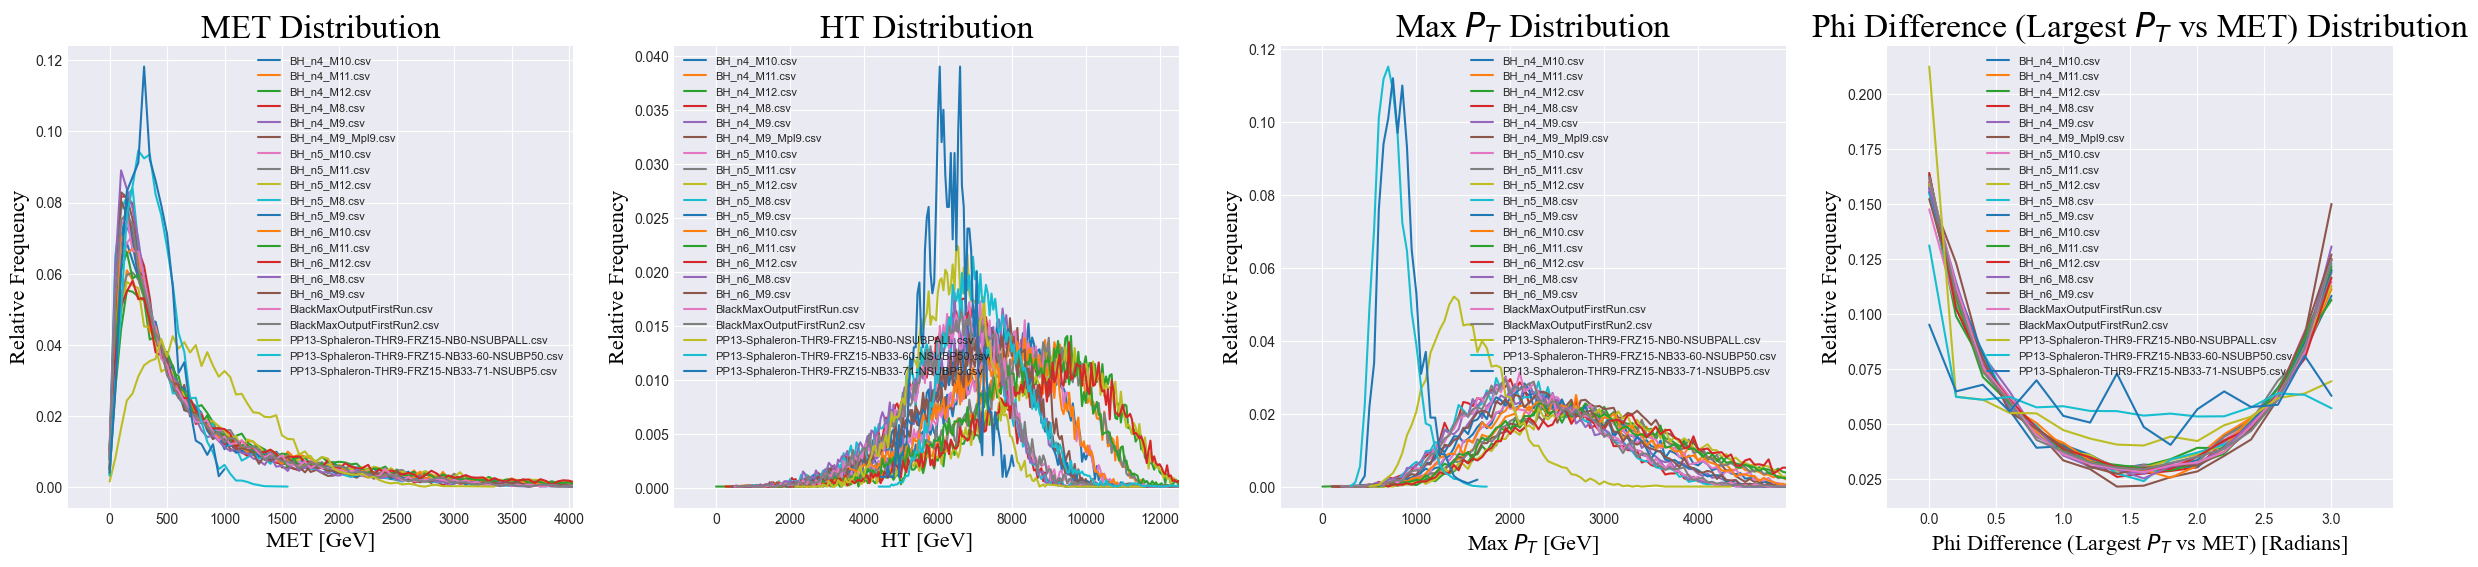

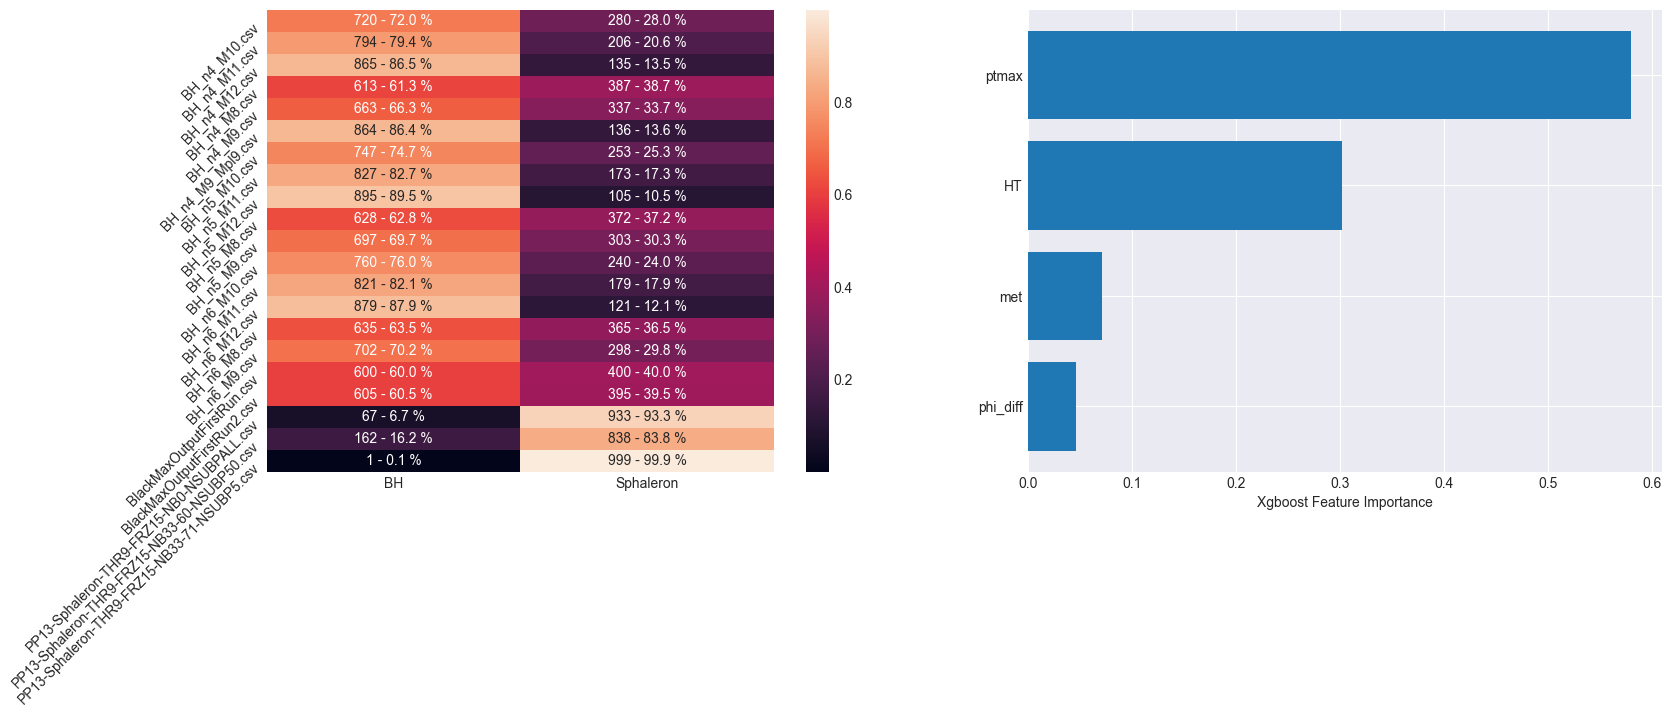

In [6]:
def split_data(y_pred, file_amounts):
    filenum = np.sum([file_amount if type(file_amount) == int else len(file_amount) for file_amount in file_amounts])
    split_num = int(len(y_pred) / filenum)
    y_pred = [y_pred[i * split_num : (i + 1) * split_num] for i in range(filenum)]

    y_pred_data = [(np.round(y_pred[i].count(0) / split_num, 3), np.round(y_pred[i].count(1) / split_num, 3)) for i in range(len(y_pred))]
    y_pred_labels = [(str(y_pred[i].count(0)) + " - " + str(np.round(y_pred[i].count(0) * 100/ split_num, 1)) + " %", str(y_pred[i].count(1)) + " - " + str(np.round(y_pred[i].count(1) * 100 / split_num, 1)) + " %") for i in range(len(y_pred))]

    return y_pred_data, y_pred_labels


file_amounts = [18, 3]
model_dataframes_input = model_dataframes
filenames_input = [[dataframe[1] for dataframe in dataframes] for dataframes in model_dataframes_input]
dataframes_input = [[dataframe[0] for dataframe in dataframes] for dataframes in model_dataframes_input]

plotter(data_variables, dataframes_input, filenames_input, filter_strengths = [0.99, 0.99, 1, 0.975, 1], binsizes = [50, 50, 0.2, 50, 0.5])

x_test, y_test = xy_data(dataframes_input, filenames_input)
ylabels = list_unpacker(filenames_input, [])

# Make predictions with model
y_pred = xgb_model.predict(x_test)
y_pred = [split_index for pred_num in y_pred for split_index, split in enumerate(splits) if pred_num in split]



y_pred_data, y_pred_labels = split_data(y_pred, file_amounts)


fig = plt.figure(figsize = (18, 6))
plt.style.use("seaborn-dark")
subplots = fig.subplots(1, 2)


x_ticks = np.arange(len(xlabels))   
y_ticks = np.arange(len(ylabels))    

import seaborn as sns

# Plot confusion matrix
ax = subplots[0]
sns.heatmap(y_pred_data, annot = y_pred_labels, fmt = "", ax = ax, xticklabels = xlabels, yticklabels = ylabels)
ax.set_yticklabels(ax.get_yticklabels(), va = "top", rotation = 45)

# Plot variables by importance for prediction
ax = subplots[1]
ax.grid()
sorted_idx = xgb_model.feature_importances_.argsort()
ax.barh(np.array(data_variables)[sorted_idx], xgb_model.feature_importances_[sorted_idx])
ax.set_xlabel("Xgboost Feature Importance")
plt.show()
plt.close()

In [7]:
# for sphal_file in range(3):
#     for black_file in range(18):
#         model_dataframes_input = [[model_dataframes[0][black_file]], [model_dataframes[1][sphal_file]]]
#         filenames_input = [[dataframe[1] for dataframe in dataframes] for dataframes in model_dataframes_input]
#         dataframes_input = [[dataframe[0] for dataframe in dataframes] for dataframes in model_dataframes_input]

#         print(filenames_input)


#         combine = [True, True]
#         xgb_model, xlabels, splits = model(dataframes_input, filenames_input, folders, combine)


#         file_amounts = [18, 3]
#         model_dataframes_input = model_dataframes
#         filenames_input = [[dataframe[1] for dataframe in dataframes] for dataframes in model_dataframes_input]
#         dataframes_input = [[dataframe[0] for dataframe in dataframes] for dataframes in model_dataframes_input]

#         # plotter(data_variables, dataframes_input, filenames_input, filter_strengths = [0.99, 0.99, 1, 0.975, 1], binsizes = [50, 50, 0.2, 50, 0.5])

#         x_test, y_test = xy_data(dataframes_input, filenames_input)
#         ylabels = list_unpacker(filenames_input, [])

#         # Make predictions with model
#         y_pred = xgb_model.predict(x_test)
#         y_pred = [split_index for pred_num in y_pred for split_index, split in enumerate(splits) if pred_num in split]



#         y_pred_data, y_pred_labels = split_data(y_pred, file_amounts)


#         fig = plt.figure(figsize = (18, 6))
#         plt.style.use("seaborn-dark")
#         subplots = fig.subplots(1, 2)


#         x_ticks = np.arange(len(xlabels))   
#         y_ticks = np.arange(len(ylabels))    

#         import seaborn as sns

#         # Plot confusion matrix
#         ax = subplots[0]
#         sns.heatmap(y_pred_data, annot = True, ax = ax, xticklabels = xlabels, yticklabels = ylabels)
#         ax.set_yticklabels(ax.get_yticklabels(), va = "top", rotation = 45)

#         # Plot variables by importance for prediction
#         ax = subplots[1]
#         ax.grid()
#         sorted_idx = xgb_model.feature_importances_.argsort()
#         ax.barh(np.array(data_variables)[sorted_idx], xgb_model.feature_importances_[sorted_idx])
#         ax.set_xlabel("Xgboost Feature Importance")
#         plt.show()
#         plt.close()